# Assignment III – Generative modeling

Welcome to assignment 3! In this notebook we will help with some parts of the code and the rest is for you to fill in. If you find any errors, or have any feedback, please contact `joelwall@kth.se` or `mats.persson@mi.physics.kth.se`.

In this assignment, to get intuition for statistical generative models, we will train a flow model to generate samples from a toy distribution in two dimensions. Then, we will move on to generating images from a data set of your choice also using a flow model. There are three image data sets to choose from, namely the same as you encountered in assignment 2:
1. `histopathology`,
2. `galaxies`,
3. `brain-stroke`.
   
To generate images we will need to define a special type of CNN called the UNet which has found great success for image tasks in a variety of different fields. If you have time and aim for a higher grade, you will in exercise 5 be asked to extend your image flow model to a diffusion model.

We will begin by defining some of the code we will need throughout the exercise, then try it out on some SDEs, and then move on to the generative modeling.

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
import torch.nn as nn
from torch.func import vmap, jacrev
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# If you are having problems with the kernel crashing upon plotting, restart the kernel and uncomment the following two lines:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

cpu


We define here a helper class for SDEs:
$$ X_t = u_t(X_t)dt + \sigma_t dW_t $$
where $u_t(X_t)$ is the drift coefficient (or vector field) and $\sigma_t$ is the diffusion coefficient.

In [2]:
class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the SDE.
        Args:
            - xt: state at time t, shape (batch_size,)
            - t: time, shape (batch_size, nts,)
        Returns:
            - drift_coefficient: shape (batch_size,)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size,)
            - t: time, shape ()
        Returns:
            - diffusion_coefficient: shape (batch_size,)
        """
        pass

## Euler Maruyama method
The Euler Maruyama method is an SDE integrator that, similar to the Euler method for ODEs, is the simplest solver for SDEs:
$$ X_{t+h} = X_t + hu_t(X_t) + \sqrt{h}\sigma_t \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0,I).$$
Hint: `torch.randn_like(x)` returns samples from a standard normal in a tensor with equal shape as `x`

In [3]:
class EulerMaruyamaMethod:
    def __init__(self, sde: SDE):
        self.sde = sde
    
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size,)
            - t: time, shape ()
            - h: time step, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        # epsilon_t can be defined as torch.randn_like(x), returns randum nums drawn from a standard normal distribution (N(0, 1))
        
        ut = self.sde.drift_coefficient(xt=xt, t=t)
        sigt = self.sde.diffusion_coefficient(xt=xt, t=t)
        epst = torch.randn_like(xt)
        nxt = xt + (h * ut) + (torch.sqrt(h) * sigt * epst)
        return nxt

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state at time ts[0], shape (batch_size,)
            - ts: timesteps, shape (batch_size, num_timesteps,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size,)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)


# Helper function needed later
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

## Brownian motion
Here you are asked to implement an SDE corresponding to Brownian motion (no drift). 

Hint: `torch.zeros_like` and `torch.ones_like` might come in handy!

In [4]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs,)
            - t: time, shape ()
        Returns:
            - drift: shape (bs,)
        """
        drift = torch.zeros_like(xt) # brownian motion is defined by ut = 0
        return drift

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs,)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs,)
        """
        diffusion = self.sigma * torch.ones_like(xt)
        return diffusion

In [11]:
def plot_trajectories_1d(x0: torch.Tensor, simulator: EulerMaruyamaMethod, timesteps: torch.Tensor, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(timesteps[trajectory_idx].cpu(), trajectory.cpu())

100%|██████████| 499/499 [00:00<00:00, 6888.92it/s]

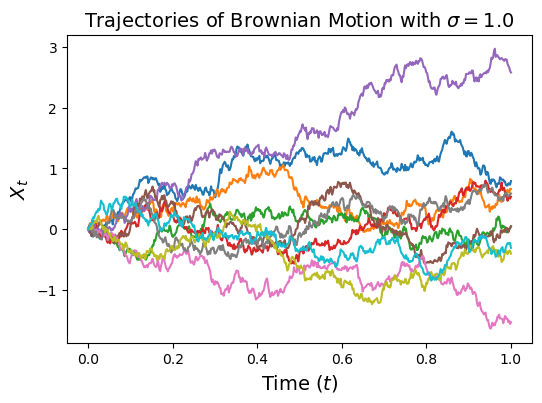

In [16]:
sigma = 1.0 # TODO: choose sigma

brownian_motion = BrownianMotion(sigma)
simulator = EulerMaruyamaMethod(sde=brownian_motion)
num_trajectories = 10
x0 = torch.zeros(num_trajectories, 1).to(device) # Initial values - let's start at zero
ts = torch.linspace(0.0, 1.0, 500).view(1,-1,1).expand(num_trajectories,-1,1).to(device)

plt.figure(figsize=(6,4))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma), fontsize=14)
ax.set_xlabel(r'Time ($t$)', fontsize=14)
ax.set_ylabel(r'$X_t$', fontsize=14)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

## Ornstein-Uhlenbeck process
Here you are asked to implement an SDE corresponding to the Ornstein-Uhlenbeck process.

In [ ]:
class OUProcess(SDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs,)
            - t: time, shape ()
        Returns:
            - drift: shape (bs,)
        """
        raise NotImplementedError("To be implemented!")

    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs,)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs,)
        """
        raise NotImplementedError("To be implemented!")

In [ ]:
# Try comparing multiple choices side-by-side
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5),
]
simulation_time = 20

num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(7 * num_plots, 4))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):

    ou_process = OUProcess(theta, sigma)
    simulator = EulerMaruyamaMethod(sde=ou_process)
    
    x0 = torch.linspace(-10.0,10.0,10).view(-1,1).to(device) # Initial values - let's start at zero
    ts = torch.linspace(0.0, simulation_time, 1000).view(1,-1,1).expand(10,-1,1).to(device)

    ax = axes[idx]
    ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=14)
    ax.set_xlabel(r'Time ($t$)', fontsize=14)
    ax.set_ylabel(r'$X_t$', fontsize=14)
    plot_trajectories_1d(x0, simulator, ts, ax)
    
plt.show()

## Noise schedulers
Let's define some helper classes for the noise schedulers $\alpha_t$ and $\beta_t$. In the cell below the helper classes, you are asked to implement linear schedulers. Again, `torch.ones_like` might come in handy. You can also define other schedulers according to your preference.

In [ ]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.zeros(1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)

class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt beta_t (num_samples, 1)
        """
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)

In [ ]:
class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples,)
        Returns:
            - alpha_t (num_samples,)
        """
        raise NotImplementedError("To be implemented!")

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples,)
        Returns:
            - d/dt alpha_t (num_samples,)
        """
        raise NotImplementedError("To be implemented!")

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples,)
        Returns:
            - beta_t (num_samples,)
        """
        raise NotImplementedError("To be implemented!")

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples,)
        Returns:
            - d/dt alpha_t (num_samples,)
        """
        raise NotImplementedError("To be implemented!")

In [ ]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """

    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (num_samples,)
        """
        pass

class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

        
class IsotropicGaussian(nn.Module, Sampleable):
    """
    Isotropic Gaussian N(0, std^2 I) producing arbitrary-shaped tensors.
    shape: the *per-sample* shape, e.g. (C,H,W) or (D,)
    """
    def __init__(self, shape, std: float = 1.0):
        super().__init__()
        self.shape = shape
        self.std = std

        # Track device
        self.register_buffer("dummy", torch.zeros(1))

    @property
    def dim(self):
        return self.shape

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.std * torch.randn(
            (num_samples, *self.shape),
            device=self.dummy.device
        )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:

        # Quadratic term: -1/(2σ²) * ||x||²
        quad = -(x.pow(2).sum(dim=1)) / (2 * self.std * self.std)
        log_norm_const = -0.5 * self.dim[0] * math.log(2 * math.pi * self.std * self.std)

        # Add normalization constant
        logp = quad + log_norm_const
        return logp.unsqueeze(1)


class GaussianMixture(nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable.
    Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> list:
        return [self.means.shape[1]]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0])
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

In [ ]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])

    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

In [ ]:
p_noise = IsotropicGaussian(shape=[2], std = 1.0).to(device)
p_data = GaussianMixture.symmetric_2D(???).to(device) # TODO: define your toy data distribution

fig, axes = plt.subplots(1,3, figsize=(24,8))
bins = 200

scale = 15
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

axes[0].set_title('Noise distribution', fontsize=16)
axes[0].set_xticks([])
axes[0].set_yticks([])
imshow_density(density=p_noise, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[0], vmin=-10, alpha=0.35, cmap=plt.get_cmap('Greys'))


axes[1].set_title(r'Toy data distribution $p_{\text{data}}$', fontsize=16)
axes[1].set_xticks([])
axes[1].set_yticks([])
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[1], vmin=-10, alpha=0.35, cmap=plt.get_cmap('Blues'))

axes[2].set_title(r'Noise distribution and $p_{\text{data}}$', fontsize=16)
axes[2].set_xticks([])
axes[2].set_yticks([])
imshow_density(density=p_noise, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.35, cmap=plt.get_cmap('Greys'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.35, cmap=plt.get_cmap('Blues'))

## The reverse process
Here we define a class called `ReverseProcess` which we can use to sample data, noise corrupted data, the conditional vector field, and the conditional score function.

In [ ]:
class ReverseProcess(nn.Module, ABC):
    def __init__(self, p_data: Sampleable, alpha: Alpha, beta: Beta):
        super().__init__()
        self.p_noise = IsotropicGaussian(p_data.dim, 1.0)
        self.p_data = p_data

        self.alpha = alpha
        self.beta = beta

    def sample_data(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        return p_data.sample(num_samples)

    def sample_noise(self, z) -> torch.Tensor:
        """
        Samples Gaussian noise from N(0, I)
        Args:
            - z: samples from p(z), (num_samples, dim)
        Returns:
            - e: samples from N(0, I), (num_samples, dim)
        """
        return torch.randn_like(z)

    def sample_xt(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - e: samples from N(0, I), (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        e = self.sample_noise(z)

        raise NotImplementedError("To be implemented!")

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)
    
        raise NotImplementedError("To be implemented!")

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

In [ ]:
num_timesteps = 5

# Initialize probability path
path = ReverseProcess(
    p_data = p_data,
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample
num_samples = 1000
z = # TODO: sample data from path

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_timesteps, 6))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1).expand(num_samples, 1)
    imshow_density(density=path.p_noise, x_bounds=x_bounds, y_bounds=y_bounds, ax=axes[tidx], bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Greys'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, ax=axes[tidx], bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
    xt = path.sample_xt(z, tt)
    axes[tidx].scatter(xt[:,0].detach().cpu(), xt[:,1].detach().cpu(), s=1, alpha=0.25, color='black')
    axes[tidx].axis("off")
    axes[tidx].set_title(f'$t={t}$', fontsize=24)
plt.show()

## MLP
Now we come to the network architecture. Implement an MLP architecture that given a list of hidden dimensions `hiddens` and input dimension `dim` outputs something with dimension `dim-1` where we subtract 1 since the time variable in the input is one-dimensional.

In [ ]:
class MLP(nn.Module):
    """
    MLP-parameterization of the vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int], activation: Type[nn.Module] = nn.SiLU):
        super().__init__()
        self.dim = dim
        self.net = # implement the architecture using hiddens (list of hidden dimensions), and apply activation() after each layer

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        - t: (bs, 1)
        Returns:
        - epsilon_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1) # 3 dimensional
        return self.net(xt)

## Training loop
Define the `get_train_loss` method according to Algorithm 1. It should sample data from `self.path` and compute the loss between the model output and the conditional vector field.

In [ ]:
class Trainer:
    def __init__(self, path: ReverseProcess, model: nn.Module):
        super().__init__()
        self.path = path
        self.model = model

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z = # sample data from path
        t = torch.rand(batch_size, *[1]*(z.ndim-1), device=device)
        x = # sample corrupted data from path
        
        ut_theta = self.model(x, t)

        ut_ref = # sample conditional vector field

        error = torch.sum(torch.square(ut_theta - ut_ref), dim=-1) # (bs,)

        return torch.mean(error)

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, batch_size: int, num_epochs: int, device: torch.device, lr: float = 1e-3) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(batch_size)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

        # Finish
        self.model.eval()

In [ ]:
# Construct learnable vector field
mlp = MLP(dim=, hiddens=) # TODO: define the input dimension and hidden layer dimensions

# Construct trainer
trainer = Trainer(path, mlp)
losses = trainer.train(num_epochs=1000, device=device, lr=1e-3, batch_size=1000)

We need to wrap our model in an SDE class to be able to simulate the flow ODE:

In [ ]:
class LearnedODE(SDE):
    def __init__(self, net):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        
        return self.net(x,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        return torch.zeros_like(x)

In [ ]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 4


##############
# Setup Plot #
##############
scale = 15
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size = 20
markerscale = 1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))


ax = axes[1]
ax.set_title("Samples from Learned SDE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_noise, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Greys'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

# Construct integrator and plot trajectories
ode = LearnedODE(mlp)
simulator = EulerMaruyamaMethod(ode)
x0 = path.p_noise.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)

xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


ax = axes[2]
ax.set_title("Trajectories of Learned SDE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=path.p_noise, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Greys'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

n_traj_to_plot = num_samples // 5 if num_samples > 100 else num_samples
for traj_idx in range(n_traj_to_plot):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')



ax = axes[0]
ax.set_title("Ground-Truth Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = path.sample_data(num_samples)
    x = path.sample_xt(zz, tt)
    ax.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=path.p_noise, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Greys'))
imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

# Image generation

In [ ]:
class ImageSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for your image dataset
    """
    def __init__(self):
        super().__init__()
        self.dataset_path = os.path.join('data', 'brain-stroke') # TODO: choose your image data set
        self.transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])

        self.dataset = self.load_data()
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    @property
    def dim(self):
        return self.dataset.shape[1:]

    def load_data(self):
        images = []

        for fname in os.listdir(self.dataset_path):
            if fname.endswith('.png'):
                fpath = os.path.join(self.dataset_path, fname)

                # Load image
                img = Image.open(fpath)

                # Ensure RGB
                img = img.convert('L') # TODO: 'L' if grayscale else 'RGB'

                # Apply transform -> tensor [C, H, W]
                img_tensor = self.transform(img)

                images.append(img_tensor)

        # Stack into [N, C, H, W]
        data = torch.stack(images, dim=0)

        return data

    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples = [self.dataset[i] for i in indices]
        samples = torch.stack(samples).to(self.dummy)
        return samples

In [ ]:
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
p_data = ImageSampler().to(device)

# Initialize probability path
path = ReverseProcess(
    p_data = p_data,
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample
num_samples = num_rows * num_cols
z = # TODO: sample data from path

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(4 * num_cols * num_timesteps, 4 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = # TODO: sample corrupted data from path
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray", interpolation='none')
    axes[tidx].axis("off")
    axes[tidx].set_title(f'$t={t}$', fontsize=36)
plt.show()

## UNet
Here we define the UNet model for our image vector field. It is you job to fill in the missing details in the residual layer module.

In [ ]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            # TODO: define the first residual block
        )
        
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        
        self.block2 = nn.Sequential(
            # TODO: define the second residual block
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        res = x.clone()                      # (bs, c, h, w)

        # Initial conv block
        x = # TODO: apply first block to x   # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = # TODO: add t_embed to x

        # Second conv block
        x = # TODO: apply second block to x  # (bs, c, h, w)

        # Add back residual
        x = # TODO: add res to x             # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Bottleneck(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed)

        return x

class UNet(nn.Module):
    def __init__(self, input_channels: int, channels: List[int], num_residual_layers: int, t_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, ic, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(nn.Conv2d(input_channels, channels[0], kernel_size=3, padding=1), nn.BatchNorm2d(channels[0]), nn.SiLU())

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Encoders, Bottleneck, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        # Final convolution
        self.final_conv = nn.Conv2d(channels[0], input_channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        Returns:
        - u_t^theta(x): (bs, 1, 32, 32)
        """
        # Embed t
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Bottleneck
        x = self.bottleneck(x, t_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

### Training
Train the UNet vector field

In [ ]:
# Initialize probability path
path = ReverseProcess(
    p_data = ImageSampler(),
    alpha = , # TODO: define your alpha scheduler
    beta =    # TODO: define your beta scheduler
).to(device)

# Initialize model
unet = UNet(
    input_channels = 1, # RGB or grayscale?
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
)

# Initialize trainer
trainer = Trainer(path = path, model = unet)

# Train!
trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

### Generate new images!

In [ ]:
num_timesteps = 100
num_samples = 9

ode = LearnedODE(unet)
simulator = EulerMaruyamaMethod(ode)
x0 = # TODO: sample initial noise from path.p_noise # (num_samples, 3, 32, 32)

# Simulate
ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
x1 = # TODO: use the simulator to simulate the ODE starting in x0

plt.figure()
grid = make_grid(x1, nrow=num_cols, normalize=True, value_range=(-1,1))

plt.imshow(grid.squeeze().permute(1, 2, 0).cpu(), cmap="gray", interpolation='none')
plt.axis("off")
plt.title(f'$t={t}$', fontsize=14)